In [6]:
import pandas as pd
import os,sys, imp, glob
sys.path.append('./src/')
import doc_utils_clean as doc_utils
import feature_utils, common_utils
import defines
import numpy as np
from sklearn_crfsuite import scorers, CRF
from sklearn_crfsuite import metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.model_selection import LeaveOneGroupOut,LeavePGroupsOut,GroupKFold

from operator import itemgetter
from sklearn_crfsuite.utils import flatten
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import random
import model_utils
import seaborn as sns
import matplotlib.pyplot as plt
import json
from collections import Counter
import scipy
import nltk

import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.pipeline import Pipeline


In [223]:
dir_name="reparse"

In [224]:
db_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name)
db_path

'/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse'

In [225]:
glob.glob(os.path.join(db_path,"*sc*merged*"))

['/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/58_scaled.binary0.50_merged.csv',
 '/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/33_scaled.no.binary_merged.csv',
 '/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/46_scaled.no.binary_merged.csv',
 '/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/31_scaled.no.binary_merged.csv',
 '/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/44_scaled.no.binary_merged.csv',
 '/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/37_scaled.no.binary_merged.csv',
 '/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/42_scaled.no.binary_merged.csv',
 '/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/44_scaled.binary0.50_merged.csv',
 '/scratch/sim_reg6/users/zsof

### Check parsing

In [226]:
dir_name='reparse'

In [222]:
imp.reload(model_utils)
doc_idx=5
model_utils.assemble_test_from_parsed(dir_name,doc_idx)

## Scaled TOKEN, sent_len, binary, use stop_word

In [227]:
imp.reload(feature_utils)
docs_map = feature_utils.pack_all_doc_sentences_to_map(dir_name,
                                                              per_par=True,
                                                              limit=0,
                                                              doc_as_sequence=1,
                                                              sent_lemma_db_list=[],
                                                              tf_types = ['word','lemma','char_wb'],
                                                              merged_str = 'scaled.binary0.50_merged',
                                                              tf_suffix='_stop'
                                                             )

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 
14924 items packed for 80 docs


In [228]:
imp.reload(common_utils)
common_utils.get_random_sample(docs_map)
imp.reload(feature_utils)
imp.reload(model_utils)
seq_len=3
step=3
per_par=True
feature_utils.reshape_docs_map_to_seq(docs_map,per_par,seq_len,step)

[49] 206 -> 69 [76] 132 -> 44 [63] 338 -> 113 [42] 136 -> 46 [57] 271 -> 91 [68] 439 -> 147 [15] 121 -> 41 [34] 49 -> 17 [21] 108 -> 36 [18] 63 -> 21 [32] 73 -> 25 [27] 67 -> 23 [6] 420 -> 140 [13] 90 -> 30 [39] 111 -> 37 [44] 199 -> 67 [51] 208 -> 70 [70] 183 -> 61 [65] 335 -> 112 [69] 517 -> 173 [43] 99 -> 33 [56] 268 -> 90 [77] 176 -> 59 [62] 249 -> 83 [48] 223 -> 75 [35] 63 -> 21 [20] 90 -> 30 [1] 203 -> 68 [14] 129 -> 43 [38] 90 -> 30 [7] 249 -> 83 [12] 150 -> 50 [33] 91 -> 31 [26] 114 -> 38 [19] 265 -> 89 [71] 156 -> 52 [64] 347 -> 116 [45] 204 -> 68 [50] 184 -> 62 [23] 74 -> 25 [36] 87 -> 29 [9] 276 -> 92 [80] 223 -> 75 [28] 167 -> 56 [17] 322 -> 108 [2] 156 -> 52 [55] 249 -> 83 [40] 148 -> 50 [61] 433 -> 145 [74] 95 -> 32 [67] 407 -> 136 [72] 421 -> 141 [58] 384 -> 128 [79] 172 -> 58 [53] 149 -> 50 [46] 200 -> 67 [11] 121 -> 41 [4] 132 -> 44 [25] 122 -> 41 [30] 82 -> 28 [16] 102 -> 34 [3] 113 -> 38 [29] 105 -> 35 [8] 82 -> 28 [22] 89 -> 30 [37] 100 -> 34 [60] 246 -> 82 [75] 68 

In [229]:
docs_map[1].keys()
for key,item in docs_map.items():
    del docs_map[key]['groups']
    del docs_map[key]['X']
    del docs_map[key]['y']

docs_map[1].keys()


dict_keys(['X_3_3', 'y_3_3', 'groups_3_3'])

In [230]:
import json
imp.reload(common_utils)
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"scaled.binary.5_stop_docs_map.json")

with open(json_path, 'w') as fp:
    json.dump(docs_map, fp)

In [231]:
imp.reload(common_utils)
common_utils.get_random_sample(docs_map)

[{'is_question': 0.0,
  'par_pos_in_doc': 0.6728971962616822,
  'sent_len': 0.0801204819277108,
  'is_client': 0.5,
  'sent_pos_in_par': 0.1666666666666666,
  'sent_pos_in_doc': 0.8014184397163121,
  'TOKEN': 0.1575757575757575,
  'POSTAG_AT': 0.074074074074074,
  'POSTAG_BN': 0.037037037037037,
  'POSTAG_BNT': 0.037037037037037,
  'POSTAG_CONJ': 0.074074074074074,
  'POSTAG_DEF': 0.1851851851851851,
  'POSTAG_EX': 0.037037037037037,
  'POSTAG_IN': 0.1111111111111111,
  'POSTAG_JJ': 0.037037037037037,
  'POSTAG_NN': 0.2592592592592592,
  'POSTAG_POS': 0.074074074074074,
  'POSTAG_PREPOSITION': 0.1851851851851851,
  'POSTAG_PRP': 0.1481481481481481,
  'POSTAG_RB': 0.1111111111111111,
  'POSTAG_REL': 0.074074074074074,
  'POSTAG_S_PRN': 0.1481481481481481,
  'POSTAG_VB': 0.074074074074074,
  'f_gen_F': 0.074074074074074,
  'f_gen_M': 0.5925925925925926,
  'f_num_P': 0.074074074074074,
  'f_num_S': 0.5925925925925926,
  'f_per_1': 0.2222222222222222,
  'f_per_3': 0.074074074074074,
  'f_p

In [61]:
imp.reload(model_utils)
test_percent = 0.2
seed=42
n_splits=1
n_groups=int(test_percent*len(docs_map.keys()))
print("Split {} times, leave {} groups out".format(n_splits,n_groups))
my_cv=model_utils.MyLeavePGroupsOut(n_splits=n_splits,n_groups=n_groups)

Split 1 times, leave 16 groups out


In [62]:
groups=list(docs_map.keys())
# groups

In [63]:
for tr,tx in my_cv.split(X=groups,groups=groups):
    print(tr,tx)

[ 1  2  3  4  5  6  8  9 10 11 12 15 16 17 18 19 20 21 22 23 24 25 26 27
 30 33 34 35 36 37 38 39 40 41 43 44 45 47 48 49 50 51 52 53 54 55 56 59
 60 63 65 66 67 68 69 70 71 72 73 74 75 76 77 78] [ 7 13 14 28 29 31 32 42 46 57 58 61 62 64 79 80]


In [64]:
imp.reload(model_utils)
for tr,ts in my_cv.split(X=list(docs_map.keys()),groups=list(docs_map.keys())):
    print(tr[:5],ts[:5])
    X_train,y_train,groups_train =  model_utils.get_X_y_by_doc_indices(docs_map,tr,seq_len,step)
    X_test,y_test,groups_test =  model_utils.get_X_y_by_doc_indices(docs_map,ts,seq_len,step)

[1 2 3 4 5] [ 7 13 14 28 29]


In [66]:
type(X_train),len(y_train),len(groups_train)

(list, 3893, 3893)

In [68]:
len(set(groups_train))

64

In [78]:
imp.reload(model_utils)
n_groups=int(test_percent*len(set(groups_train)))
n_splits=3
my_cv=model_utils.ByDocFold(n_groups=n_groups,n_splits=n_splits)
for tr,ts in my_cv.split(X_train,y_train,groups_train):
    print(tr[:5],ts[:5])
#     print(X_train[tr[0]][0],y_train[tr[0]][0])

[0, 1, 2, 3, 4] [158, 159, 160, 161, 162]
[0, 1, 2, 3, 4] [68, 69, 70, 71, 72]
[0, 1, 2, 3, 4] [68, 69, 70, 71, 72]


### Cross-validate on ALL data

In [262]:
imp.reload(common_utils)
X,y,groups=model_utils.get_X_y_by_doc_indices(docs_map,list(docs_map.keys()),seq_len,step)

In [263]:
len(set(groups))

80

In [264]:
n_groups=int(test_percent*len(set(groups)))
n_splits=10
my_cv=model_utils.ByDocFold(n_groups=n_groups,n_splits=n_splits)
for tr,ts in my_cv.split(X,y,groups):
    print (set(itemgetter(*ts)(groups)))

{65, 36, 58, 70, 4, 5, 75, 76, 12, 79, 54, 55, 26, 28, 29, 30}
{1, 34, 36, 6, 44, 13, 77, 14, 12, 49, 45, 46, 20, 21, 55, 28}
{69, 6, 38, 71, 9, 74, 11, 76, 13, 79, 16, 49, 47, 25, 59, 30}
{32, 35, 36, 69, 59, 10, 76, 46, 47, 48, 49, 80, 21, 22, 27, 60}
{64, 35, 69, 5, 72, 9, 42, 8, 41, 73, 80, 51, 52, 28, 29, 30}
{32, 64, 34, 66, 69, 72, 12, 77, 78, 47, 18, 19, 52, 55, 59, 29}
{33, 2, 35, 68, 7, 71, 9, 44, 15, 79, 49, 50, 20, 21, 55, 60}
{65, 34, 1, 38, 39, 72, 74, 14, 78, 48, 20, 21, 23, 56, 26, 59}
{1, 67, 68, 3, 70, 40, 8, 42, 11, 75, 77, 15, 80, 47, 31, 63}
{34, 68, 69, 71, 40, 9, 78, 48, 17, 52, 22, 55, 57, 26, 28, 61}


### Use GroupKFold

In [265]:
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=10)
for tr,ts in gkf.split(X,y,groups):
    print (set(itemgetter(*ts)(groups)))


{2, 35, 69, 37, 10, 46, 30, 62}
{32, 33, 68, 12, 80, 55, 28, 29}
{36, 4, 70, 45, 19, 25, 27, 61}
{72, 8, 13, 47, 48, 21, 53, 56}
{6, 39, 38, 44, 78, 51, 57, 31}
{67, 73, 75, 76, 15, 52, 24, 60}
{34, 7, 40, 9, 43, 79, 16, 58}
{5, 11, 14, 49, 50, 17, 22, 59}
{65, 1, 66, 42, 74, 77, 18, 26}
{64, 3, 71, 41, 20, 54, 23, 63}


### Use my GroupSplitFold - define n_groups_out and n_splits

In [268]:
import model_utils
imp.reload(model_utils)
n_groups=int(test_percent*len(set(groups)))
gsf = model_utils.GroupSplitFold(n_splits=3,n_groups=n_groups)
for tr,ts in gsf.split(X=X,groups=groups,seed=42):
    print (set(itemgetter(*ts)(groups)))

{64, 65, 67, 58, 4, 3, 8, 9, 10, 76, 13, 46, 23, 26, 27, 29}
{1, 66, 37, 72, 42, 74, 44, 78, 47, 49, 50, 51, 22, 57, 28, 30}
{32, 33, 35, 5, 7, 71, 43, 75, 77, 14, 16, 18, 56, 59, 62, 31}


In [298]:
%%time
# define fixed parameters and parameters to search

crf_scaled = CRF(
    max_iterations=100,
    all_possible_transitions=True,
    algorithm='lbfgs'
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
    'min_freq': np.arange(1,11,2),
#     'epsilon':scipy.stats.expon(scale=0.00005),
#     'delta':scipy.stats.expon(scale=0.00005)
}

labels = ['not_nar','is_nar']
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs_scaled = RandomizedSearchCV(crf_scaled, params_space,
                        cv=gsf,
                        verbose=2,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer,
                        random_state=4)

rs_scaled.fit(X=X, y=y,groups=groups)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
CPU times: user 7min 20s, sys: 1min 31s, total: 8min 51s
Wall time: 9min 30s


RandomizedSearchCV(cv=<model_utils.GroupSplitFold object at 0x2b8ba92512b0>,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b8c46f39580>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b8c096ecfd0>,
                                        'min_freq': array([1, 3, 5, 7, 9])},
                   random_state=4,
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['not_nar', 'is_nar']),
                   verbose=2)

date and time = 20.07_06:23:26


In [299]:
# crf = rs.best_estimator_
print('best params:', rs_scaled.best_params_)
print('best CV score:', rs_scaled.best_score_)
print('model size: {:0.2f}M'.format(rs_scaled.best_estimator_.size_ / 1000000))

best params: {'c1': 0.5850178031143265, 'c2': 0.052554161623508414, 'min_freq': 3}
best CV score: 0.8016012347690115
model size: 0.47M


In [300]:
rs_scaled

RandomizedSearchCV(cv=<model_utils.GroupSplitFold object at 0x2b8ba92512b0>,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b8c46f39580>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b8c096ecfd0>,
                                        'min_freq': array([1, 3, 5, 7, 9])},
                   random_state=4,
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['not_nar', 'is_nar']),
                   verbose=2)

In [303]:
dir_name
score="{:.3f}".format(rs_scaled.best_score_).lstrip('0')
score

'.802'

In [304]:
import json
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%d.%m_%H:%M")
print("date and time =", dt_string)

json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"{}_{}_best_params.json".format(score,dt_string))

best_params_pyth = common_utils.convert_to_python_types(rs_scaled.best_params_)
with open(json_path, 'w') as fp:
    json.dump(best_params_pyth, fp)


date and time = 21.07_07:26



              precision    recall  f1-score   support

     not_nar       0.81      0.89      0.85      5804
      is_nar       0.62      0.46      0.53      2182

    accuracy                           0.78      7986
   macro avg       0.72      0.68      0.69      7986
weighted avg       0.76      0.78      0.76      7986



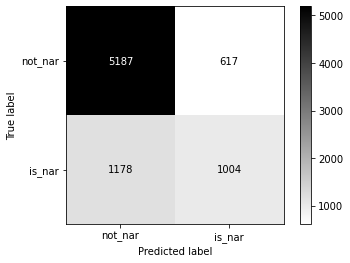

In [84]:
best_crf = rs_scaled.best_estimator_
y_pred  =  best_crf.predict(X_test)
feature_utils.get_prediction_report(flatten(y_test),flatten(y_pred),best_crf.classes_)

### Scaled , No stop words

In [87]:
imp.reload(feature_utils)
docs_map_2 = feature_utils.pack_all_doc_sentences_to_map(dir_name,
                                                              per_par=True,
                                                              limit=0,
                                                              doc_as_sequence=1,
                                                              sent_lemma_db_list=[],
                                                              tf_types = ['word','lemma','char_wb'],
                                                              merged_str = 'scaled.binary0.50_merged',
                                                              tf_suffix=''
                                                             )

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 
14924 items packed for 80 docs


In [91]:
feature_utils.reshape_docs_map_to_seq(docs_map_2,per_par,seq_len,step)

[49] 206 -> 69 [76] 132 -> 44 [63] 338 -> 113 [42] 136 -> 46 [57] 271 -> 91 [68] 439 -> 147 [15] 121 -> 41 [34] 49 -> 17 [21] 108 -> 36 [18] 63 -> 21 [32] 73 -> 25 [27] 67 -> 23 [6] 420 -> 140 [13] 90 -> 30 [39] 111 -> 37 [44] 199 -> 67 [51] 208 -> 70 [70] 183 -> 61 [65] 335 -> 112 [69] 517 -> 173 [43] 99 -> 33 [56] 268 -> 90 [77] 176 -> 59 [62] 249 -> 83 [48] 223 -> 75 [35] 63 -> 21 [20] 90 -> 30 [1] 203 -> 68 [14] 129 -> 43 [38] 90 -> 30 [7] 249 -> 83 [12] 150 -> 50 [33] 91 -> 31 [26] 114 -> 38 [19] 265 -> 89 [71] 156 -> 52 [64] 347 -> 116 [45] 204 -> 68 [50] 184 -> 62 [23] 74 -> 25 [36] 87 -> 29 [9] 276 -> 92 [80] 223 -> 75 [28] 167 -> 56 [17] 322 -> 108 [2] 156 -> 52 [55] 249 -> 83 [40] 148 -> 50 [61] 433 -> 145 [74] 95 -> 32 [67] 407 -> 136 [72] 421 -> 141 [58] 384 -> 128 [79] 172 -> 58 [53] 149 -> 50 [46] 200 -> 67 [11] 121 -> 41 [4] 132 -> 44 [25] 122 -> 41 [30] 82 -> 28 [16] 102 -> 34 [3] 113 -> 38 [29] 105 -> 35 [8] 82 -> 28 [22] 89 -> 30 [37] 100 -> 34 [60] 246 -> 82 [75] 68 

In [108]:
for key,item in docs_map_2.items():
    del docs_map_2[key]['X']
    del docs_map_2[key]['y']
    del docs_map_2[key]['groups']


In [116]:
imp.reload(common_utils)
common_utils.get_random_sample(docs_map_2)

[{'is_question': 0.5,
  'par_pos_in_doc': 0.912751677852349,
  'sent_len': 0.0024096385542168,
  'is_client': 0.0,
  'sent_pos_in_par': 1.0,
  'sent_pos_in_doc': 0.9635036496350364,
  'POSTAG_DEF': 1.0,
  'POSTAG_NN': 1.0,
  'POSTAG_PREPOSITION': 1.0,
  'f_gen_M': 1.0,
  'f_num_S': 1.0,
  '-1:is_question': 0.0,
  '-1:par_pos_in_doc': 0.906040268456376,
  '-1:sent_len': 0.0048192771084337,
  '-1:is_client': 0.5,
  '-1:sent_pos_in_par': 1.0,
  '-1:sent_pos_in_doc': 0.9610705596107056,
  '-1:TOKEN': 0.006060606060606,
  '-1:POSTAG_BN': 0.5,
  '-1:POSTAG_DEF': 0.5,
  '-1:POSTAG_NN': 0.5,
  '-1:POSTAG_PREPOSITION': 0.5,
  '-1:f_gen_M': 1.0,
  '-1:f_num_S': 1.0,
  '-1:f_per_A': 0.5,
  '+1:is_question': 0.0,
  '+1:par_pos_in_doc': 0.9194630872483222,
  '+1:sent_len': 0.0006024096385542,
  '+1:is_client': 0.5,
  '+1:sent_pos_in_par': 1.0,
  '+1:sent_pos_in_doc': 0.9659367396593674,
  '+1:POSTAG_RB': 1.0,
  '-2:is_question': 0.0,
  '-2:par_pos_in_doc': 0.8993288590604027,
  '-2:sent_len': 0.006

In [117]:
import json
imp.reload(common_utils)
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"sacled.no.stop_docs_map.json")

with open(json_path, 'w') as fp:
    json.dump(docs_map_2, fp)

In [94]:
imp.reload(model_utils)
test_percent = 0.2
seed=42
n_splits=1
n_groups=int(test_percent*len(docs_map.keys()))
print("Split {} times, leave {} groups out".format(n_splits,n_groups))
my_cv=model_utils.MyLeavePGroupsOut(n_splits=n_splits,n_groups=n_groups)

Split 1 times, leave 16 groups out


In [95]:
for tr,ts in my_cv.split(X=list(docs_map.keys()),groups=list(docs_map.keys())):
    
    X_train,y_train,groups_train =  model_utils.get_X_y_by_doc_indices(docs_map_2,tr,seq_len,step)
    X_test,y_test,groups_test =  model_utils.get_X_y_by_doc_indices(docs_map_2,ts,seq_len,step)

In [96]:
len(y_train)

3893

In [97]:
%%time
# define fixed parameters and parameters to search

n_groups=int(test_percent*len(set(groups_train)))
n_splits=3
my_cv=model_utils.ByDocFold(n_groups=n_groups,n_splits=n_splits)
crf = CRF(
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
    'algorithm': ['lbfgs' ,'l2sgd','ap','pa','arow'],
    'min_freq': np.arange(1,11,2) 
}

labels = ['not_nar','is_nar']
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=my_cv,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)


rs.fit(X=X_train, y=y_train,groups=groups_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
123 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimator.py", line 310, in fit
    trainer = self._get_trainer()
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimat

CPU times: user 4min 43s, sys: 51.6 s, total: 5min 34s
Wall time: 5min 57s


RandomizedSearchCV(cv=<model_utils.ByDocFold object at 0x2b8b7b7dbf70>,
                   estimator=CRF(all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['lbfgs', 'l2sgd', 'ap',
                                                      'pa', 'arow'],
                                        'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b8b7b7e2370>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b8b7b7e25e0>,
                                        'min_freq': array([1, 3, 5, 7, 9])},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['not_nar', 'is_nar']),
                   verbose=1)

In [98]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'algorithm': 'lbfgs', 'c1': 0.7289371353060703, 'c2': 0.08148877756812545, 'min_freq': 3}
best CV score: 0.7644332850605596
model size: 0.29M



              precision    recall  f1-score   support

     not_nar       0.81      0.90      0.85      5804
      is_nar       0.62      0.44      0.51      2182

    accuracy                           0.77      7986
   macro avg       0.72      0.67      0.68      7986
weighted avg       0.76      0.77      0.76      7986



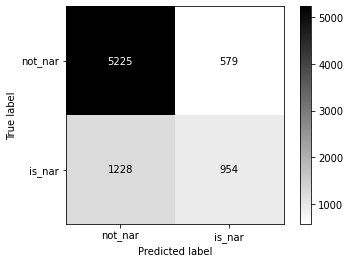

In [99]:
best_crf = rs.best_estimator_
y_pred  =  best_crf.predict(X_test)
feature_utils.get_prediction_report(flatten(y_test),flatten(y_pred),best_crf.classes_)

### No Scaled , no stop words

In [111]:
imp.reload(feature_utils)
docs_map_3 = feature_utils.pack_all_doc_sentences_to_map(dir_name,
                                                              per_par=True,
                                                              limit=0,
                                                              doc_as_sequence=1,
                                                              sent_lemma_db_list=[],
                                                              tf_types = ['word','lemma','char_wb'],
                                                              merged_str = 'merged_db',
                                                              tf_suffix=''
                                                             )

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 
14924 items packed for 80 docs


In [118]:
feature_utils.reshape_docs_map_to_seq(docs_map_3,per_par,seq_len,step)

[49] 206 -> 69 [76] 132 -> 44 [63] 338 -> 113 [42] 136 -> 46 [57] 271 -> 91 [68] 439 -> 147 [15] 121 -> 41 [34] 49 -> 17 [21] 108 -> 36 [18] 63 -> 21 [32] 73 -> 25 [27] 67 -> 23 [6] 420 -> 140 [13] 90 -> 30 [39] 111 -> 37 [44] 199 -> 67 [51] 208 -> 70 [70] 183 -> 61 [65] 335 -> 112 [69] 517 -> 173 [43] 99 -> 33 [56] 268 -> 90 [77] 176 -> 59 [62] 249 -> 83 [48] 223 -> 75 [35] 63 -> 21 [20] 90 -> 30 [1] 203 -> 68 [14] 129 -> 43 [38] 90 -> 30 [7] 249 -> 83 [12] 150 -> 50 [33] 91 -> 31 [26] 114 -> 38 [19] 265 -> 89 [71] 156 -> 52 [64] 347 -> 116 [45] 204 -> 68 [50] 184 -> 62 [23] 74 -> 25 [36] 87 -> 29 [9] 276 -> 92 [80] 223 -> 75 [28] 167 -> 56 [17] 322 -> 108 [2] 156 -> 52 [55] 249 -> 83 [40] 148 -> 50 [61] 433 -> 145 [74] 95 -> 32 [67] 407 -> 136 [72] 421 -> 141 [58] 384 -> 128 [79] 172 -> 58 [53] 149 -> 50 [46] 200 -> 67 [11] 121 -> 41 [4] 132 -> 44 [25] 122 -> 41 [30] 82 -> 28 [16] 102 -> 34 [3] 113 -> 38 [29] 105 -> 35 [8] 82 -> 28 [22] 89 -> 30 [37] 100 -> 34 [60] 246 -> 82 [75] 68 

In [127]:
imp.reload(common_utils)
common_utils.get_random_sample(docs_map_3)

[{'is_question': 1.0,
  'par_pos_in_doc': 0.1643835616438356,
  'sent_len': 112.0,
  'is_client': 0,
  'sent_pos_in_par': 1.0,
  'sent_pos_in_doc': 0.2222222222222222,
  'TOKEN': 24,
  'POSTAG_AT': 0.0833333333333333,
  'POSTAG_CONJ': 0.0833333333333333,
  'POSTAG_DTT': 0.0416666666666666,
  'POSTAG_IN': 0.0416666666666666,
  'POSTAG_JJ': 0.0416666666666666,
  'POSTAG_MD': 0.0416666666666666,
  'POSTAG_NN': 0.125,
  'POSTAG_NNT': 0.0416666666666666,
  'POSTAG_PREPOSITION': 0.125,
  'POSTAG_PRP': 0.125,
  'POSTAG_QW': 0.125,
  'POSTAG_RB': 0.1666666666666666,
  'POSTAG_S_PRN': 0.0833333333333333,
  'POSTAG_VB': 0.1666666666666666,
  'f_gen_F': 0.25,
  'f_gen_M': 0.3333333333333333,
  'f_num_S': 0.5833333333333334,
  'f_per_2': 0.1666666666666666,
  'f_per_3': 0.1666666666666666,
  'f_per_A': 0.0416666666666666,
  'f_tense_PAST': 0.125,
  '-1:is_question': 0.0,
  '-1:par_pos_in_doc': 0.1506849315068493,
  '-1:sent_len': 23.0,
  '-1:is_client': 1,
  '-1:sent_pos_in_par': 1.0,
  '-1:sent_p

In [121]:
docs_map_3[1].keys()

dict_keys(['X', 'y', 'groups', 'X_3_3', 'y_3_3', 'groups_3_3'])

In [123]:
imp.reload(model_utils)
test_percent = 0.2
seed=42
n_splits=1
n_groups=int(test_percent*len(docs_map_3.keys()))
print("Split {} times, leave {} groups out".format(n_splits,n_groups))
my_init_cv=model_utils.MyLeavePGroupsOut(n_splits=n_splits,n_groups=n_groups)
for tr,ts in my_init_cv.split(X=list(docs_map_3.keys()),groups=list(docs_map_3.keys())):
    X_train,y_train,groups_train =  model_utils.get_X_y_by_doc_indices(docs_map_3,tr,seq_len,step)
    X_test,y_test,groups_test =  model_utils.get_X_y_by_doc_indices(docs_map_3,ts,seq_len,step)

Split 1 times, leave 16 groups out


In [124]:
len(y_train)

3893

In [125]:
%%time
# define fixed parameters and parameters to search

n_groups=int(test_percent*len(set(groups_train)))
n_splits=3
my_cv=model_utils.ByDocFold(n_groups=n_groups,n_splits=n_splits)
crf = CRF(
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
    'algorithm': ['lbfgs' ,'l2sgd','ap','pa','arow'],
    'min_freq': np.arange(1,11,2) 
}

labels = ['not_nar','is_nar']
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=my_cv,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)


rs.fit(X=X_train, y=y_train,groups=groups_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
123 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimator.py", line 310, in fit
    trainer = self._get_trainer()
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimat

CPU times: user 4min 41s, sys: 53.9 s, total: 5min 35s
Wall time: 5min 51s


RandomizedSearchCV(cv=<model_utils.ByDocFold object at 0x2b8a4c1e9d90>,
                   estimator=CRF(all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['lbfgs', 'l2sgd', 'ap',
                                                      'pa', 'arow'],
                                        'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b8a4c1e9460>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b8a4c1e90a0>,
                                        'min_freq': array([1, 3, 5, 7, 9])},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['not_nar', 'is_nar']),
                   verbose=1)

best params: {'algorithm': 'lbfgs', 'c1': 0.9009828438425211, 'c2': 0.021332694631164644, 'min_freq': 5}
best CV score: 0.7807756155844213
model size: 0.38M

              precision    recall  f1-score   support

     not_nar       0.80      0.93      0.86      5804
      is_nar       0.68      0.40      0.50      2182

    accuracy                           0.78      7986
   macro avg       0.74      0.66      0.68      7986
weighted avg       0.77      0.78      0.76      7986



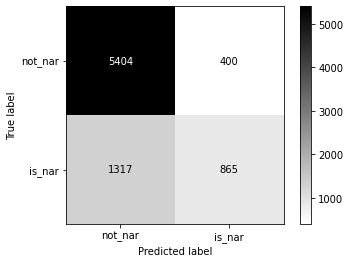

In [126]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))
best_crf = rs.best_estimator_
y_pred  =  best_crf.predict(X_test)
feature_utils.get_prediction_report(flatten(y_test),flatten(y_pred),best_crf.classes_)

### Scaled TOKEN, sent_len, keep binary, stop words

In [128]:
imp.reload(feature_utils)
docs_map_4 = feature_utils.pack_all_doc_sentences_to_map(dir_name,
                                                              per_par=True,
                                                              limit=0,
                                                              doc_as_sequence=1,
                                                              sent_lemma_db_list=[],
                                                              tf_types = ['word','lemma','char_wb'],
                                                              merged_str = 'scaled.no.binary_merged',
                                                              tf_suffix='_stop'
                                                             )

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 
14924 items packed for 80 docs


In [129]:
feature_utils.reshape_docs_map_to_seq(docs_map_4,per_par,seq_len,step)

[49] 206 -> 69 [76] 132 -> 44 [63] 338 -> 113 [42] 136 -> 46 [57] 271 -> 91 [68] 439 -> 147 [15] 121 -> 41 [34] 49 -> 17 [21] 108 -> 36 [18] 63 -> 21 [32] 73 -> 25 [27] 67 -> 23 [6] 420 -> 140 [13] 90 -> 30 [39] 111 -> 37 [44] 199 -> 67 [51] 208 -> 70 [70] 183 -> 61 [65] 335 -> 112 [69] 517 -> 173 [43] 99 -> 33 [56] 268 -> 90 [77] 176 -> 59 [62] 249 -> 83 [48] 223 -> 75 [35] 63 -> 21 [20] 90 -> 30 [1] 203 -> 68 [14] 129 -> 43 [38] 90 -> 30 [7] 249 -> 83 [12] 150 -> 50 [33] 91 -> 31 [26] 114 -> 38 [19] 265 -> 89 [71] 156 -> 52 [64] 347 -> 116 [45] 204 -> 68 [50] 184 -> 62 [23] 74 -> 25 [36] 87 -> 29 [9] 276 -> 92 [80] 223 -> 75 [28] 167 -> 56 [17] 322 -> 108 [2] 156 -> 52 [55] 249 -> 83 [40] 148 -> 50 [61] 433 -> 145 [74] 95 -> 32 [67] 407 -> 136 [72] 421 -> 141 [58] 384 -> 128 [79] 172 -> 58 [53] 149 -> 50 [46] 200 -> 67 [11] 121 -> 41 [4] 132 -> 44 [25] 122 -> 41 [30] 82 -> 28 [16] 102 -> 34 [3] 113 -> 38 [29] 105 -> 35 [8] 82 -> 28 [22] 89 -> 30 [37] 100 -> 34 [60] 246 -> 82 [75] 68 

In [134]:
imp.reload(model_utils)
test_percent = 0.2
seed=42
n_splits=1
n_groups=int(test_percent*len(docs_map_4.keys()))
print("Split {} times, leave {} groups out".format(n_splits,n_groups))
my_init_cv=model_utils.MyLeavePGroupsOut(n_splits=n_splits,n_groups=n_groups)
for tr,ts in my_init_cv.split(X=list(docs_map_3.keys()),groups=list(docs_map_4.keys())):
    X_train,y_train,groups_train =  model_utils.get_X_y_by_doc_indices(docs_map_4,tr,seq_len,step)
    X_test,y_test,groups_test =  model_utils.get_X_y_by_doc_indices(docs_map_4,ts,seq_len,step)

Split 1 times, leave 16 groups out


In [135]:
%%time
# define fixed parameters and parameters to search

n_groups=int(test_percent*len(set(groups_train)))
n_splits=3
my_cv=model_utils.ByDocFold(n_groups=n_groups,n_splits=n_splits)
crf = CRF(
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
    'algorithm': ['lbfgs' ,'l2sgd','ap','pa','arow'],
    'min_freq': np.arange(1,11,2) 
}

labels = ['not_nar','is_nar']
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=my_cv,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)


rs.fit(X=X_train, y=y_train,groups=groups_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
126 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimator.py", line 310, in fit
    trainer = self._get_trainer()
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimat

CPU times: user 4min 23s, sys: 51.7 s, total: 5min 15s
Wall time: 5min 30s


RandomizedSearchCV(cv=<model_utils.ByDocFold object at 0x2b8a2be97c10>,
                   estimator=CRF(all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['lbfgs', 'l2sgd', 'ap',
                                                      'pa', 'arow'],
                                        'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b8bd4c74d60>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b8b7b84b0d0>,
                                        'min_freq': array([1, 3, 5, 7, 9])},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['not_nar', 'is_nar']),
                   verbose=1)

best params: {'algorithm': 'lbfgs', 'c1': 0.7326889470042623, 'c2': 0.0003655902116096884, 'min_freq': 5}
best CV score: 0.792419006372561
model size: 0.25M

              precision    recall  f1-score   support

     not_nar       0.80      0.92      0.86      5804
      is_nar       0.66      0.40      0.50      2182

    accuracy                           0.78      7986
   macro avg       0.73      0.66      0.68      7986
weighted avg       0.76      0.78      0.76      7986



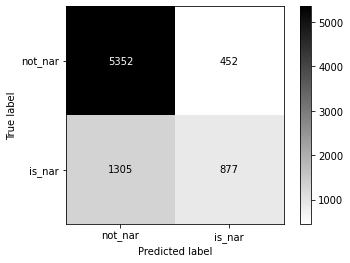

In [136]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))
best_crf = rs.best_estimator_
y_pred  =  best_crf.predict(X_test)
feature_utils.get_prediction_report(flatten(y_test),flatten(y_pred),best_crf.classes_)

### Scaled TOKEN, sent_len, keep binary, NO stop words

In [133]:
imp.reload(feature_utils)
docs_map_5 = feature_utils.pack_all_doc_sentences_to_map(dir_name,
                                                              per_par=True,
                                                              limit=0,
                                                              doc_as_sequence=1,
                                                              sent_lemma_db_list=[],
                                                              tf_types = ['word','lemma','char_wb'],
                                                              merged_str = 'scaled.no.binary_merged',
                                                              tf_suffix=''
                                                             )

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 
14924 items packed for 80 docs


In [137]:
feature_utils.reshape_docs_map_to_seq(docs_map_5,per_par,seq_len,step)
imp.reload(model_utils)
test_percent = 0.2
seed=42
n_splits=1
n_groups=int(test_percent*len(docs_map_5.keys()))
print("Split {} times, leave {} groups out".format(n_splits,n_groups))
my_init_cv=model_utils.MyLeavePGroupsOut(n_splits=n_splits,n_groups=n_groups)
for tr,ts in my_init_cv.split(X=list(docs_map_3.keys()),groups=list(docs_map_5.keys())):
    X_train,y_train,groups_train =  model_utils.get_X_y_by_doc_indices(docs_map_5,tr,seq_len,step)
    X_test,y_test,groups_test =  model_utils.get_X_y_by_doc_indices(docs_map_5,ts,seq_len,step)

[49] 206 -> 69 [76] 132 -> 44 [63] 338 -> 113 [42] 136 -> 46 [57] 271 -> 91 [68] 439 -> 147 [15] 121 -> 41 [34] 49 -> 17 [21] 108 -> 36 [18] 63 -> 21 [32] 73 -> 25 [27] 67 -> 23 [6] 420 -> 140 [13] 90 -> 30 [39] 111 -> 37 [44] 199 -> 67 [51] 208 -> 70 [70] 183 -> 61 [65] 335 -> 112 [69] 517 -> 173 [43] 99 -> 33 [56] 268 -> 90 [77] 176 -> 59 [62] 249 -> 83 [48] 223 -> 75 [35] 63 -> 21 [20] 90 -> 30 [1] 203 -> 68 [14] 129 -> 43 [38] 90 -> 30 [7] 249 -> 83 [12] 150 -> 50 [33] 91 -> 31 [26] 114 -> 38 [19] 265 -> 89 [71] 156 -> 52 [64] 347 -> 116 [45] 204 -> 68 [50] 184 -> 62 [23] 74 -> 25 [36] 87 -> 29 [9] 276 -> 92 [80] 223 -> 75 [28] 167 -> 56 [17] 322 -> 108 [2] 156 -> 52 [55] 249 -> 83 [40] 148 -> 50 [61] 433 -> 145 [74] 95 -> 32 [67] 407 -> 136 [72] 421 -> 141 [58] 384 -> 128 [79] 172 -> 58 [53] 149 -> 50 [46] 200 -> 67 [11] 121 -> 41 [4] 132 -> 44 [25] 122 -> 41 [30] 82 -> 28 [16] 102 -> 34 [3] 113 -> 38 [29] 105 -> 35 [8] 82 -> 28 [22] 89 -> 30 [37] 100 -> 34 [60] 246 -> 82 [75] 68 

In [141]:
%%time
# define fixed parameters and parameters to search

n_groups=int(test_percent*len(set(groups_train)))
n_splits=3
my_cv=model_utils.ByDocFold(n_groups=n_groups,n_splits=n_splits)
crf = CRF(
    max_iterations=100,
    all_possible_transitions=True,
    verbose = True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
    'algorithm': ['lbfgs' ,'l2sgd','ap','pa','arow'],
    'min_freq': np.arange(1,11,2),
    'linesearch': ['MoreThuente','Backtracking','StrongBacktracking'],
    'epsilon':[0.1,0.2,0.5,0.3],
    'delta':[0.1,0.2,0.5,0.3]
}


labels = ['not_nar','is_nar']
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=my_cv,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)


rs.fit(X=X_train, y=y_train,groups=groups_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
117 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimator.py", line 310, in fit
    trainer = self._get_trainer()
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimat

loading training data to CRFsuite: 100%|██████████| 3893/3893 [00:03<00:00, 1129.80it/s]



Feature generation
type: CRF1d
feature.minfreq: 3.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 18880
Seconds required: 0.870

L-BFGS optimization
c1: 0.153672
c2: 0.079136
num_memories: 6
max_iterations: 100
epsilon: 0.200000
stop: 10
delta: 0.200000
linesearch: StrongBacktracking
linesearch.max_iterations: 20

Iter 1   time=0.39  loss=16934.56 active=18567 feature_norm=0.25
Iter 2   time=0.09  loss=16306.29 active=16287 feature_norm=0.24
Iter 3   time=0.09  loss=12003.23 active=12576 feature_norm=0.65
Iter 4   time=0.09  loss=6842.73  active=15783 feature_norm=2.05
Iter 5   time=0.27  loss=6413.02  active=17826 feature_norm=2.17
Iter 6   time=0.09  loss=6201.12  active=17908 feature_norm=2.28
Iter 7   time=0.18  loss=5955.06  active=17905 feature_norm=2.41
Iter 8   time=0.09  loss=5654.05  active=18281 feature_norm=2.72
Iter 9   time=0.18  loss=5233.30  active=18347 feature_norm=2.90
Iter 10

RandomizedSearchCV(cv=<model_utils.ByDocFold object at 0x2b8c02d58790>,
                   estimator=CRF(all_possible_transitions=True,
                                 max_iterations=100, verbose=True),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['lbfgs', 'l2sgd', 'ap',
                                                      'pa', 'arow'],
                                        'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b8c02d58af0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b8c02ddf190>,
                                        'delta': [0.1, 0.2, 0.5, 0.3],
                                        'epsilon': [0.1, 0.2, 0.5, 0.3],
                                        'linesearch': ['MoreThuente',
                                                       'Backtracking',
                                                       'StrongBacktracking'],
                                        'min_freq': array([1, 3, 5, 7, 9])},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['not_nar', 'is_nar']),
                   verbose=1)

best params: {'algorithm': 'lbfgs', 'c1': 0.1536724371562968, 'c2': 0.07913588125590243, 'delta': 0.2, 'epsilon': 0.2, 'linesearch': 'StrongBacktracking', 'min_freq': 3}
best CV score: 0.7641667282761974
model size: 1.15M

              precision    recall  f1-score   support

     not_nar       0.77      0.93      0.84      5804
      is_nar       0.58      0.25      0.35      2182

    accuracy                           0.75      7986
   macro avg       0.67      0.59      0.59      7986
weighted avg       0.72      0.75      0.71      7986



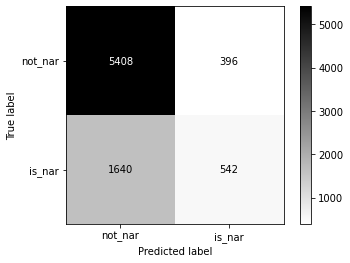

In [142]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))
best_crf = rs.best_estimator_
y_pred  =  best_crf.predict(X_test)
feature_utils.get_prediction_report(flatten(y_test),flatten(y_pred),best_crf.classes_)

## Use same seed as for .84 tfidf - from docs_map_5

In [144]:
imp.reload(model_utils)
test_percent = 0.2
seed=42
num_splits=10
X_train,y_train,X_test,y_test,test_idx,groups_train,groups_test =  model_utils.split_test_train_docs(docs_map_5,test_percent,seq_len,step,seed)

In [146]:
len(y_test),len(groups_test),len(y_train)

(849, 849, 4152)

### Use cv = 3

In [147]:
%%time
# define fixed parameters and parameters to search
crf = CRF(
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
    'algorithm': ['lbfgs' ,'l2sgd','ap','pa','arow'],
    'min_freq': np.arange(1,11,2) 
}

labels = ['not_nar','is_nar']
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)


rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
135 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimator.py", line 310, in fit
    trainer = self._get_trainer()
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimat

CPU times: user 4min 38s, sys: 54.3 s, total: 5min 32s
Wall time: 5min 59s


RandomizedSearchCV(cv=3,
                   estimator=CRF(all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['lbfgs', 'l2sgd', 'ap',
                                                      'pa', 'arow'],
                                        'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b8c02bdc490>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b8c02bdc6a0>,
                                        'min_freq': array([1, 3, 5, 7, 9])},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['not_nar', 'is_nar']),
                   verbose=1)

best params: {'algorithm': 'lbfgs', 'c1': 0.5051665887195089, 'c2': 0.012430930785204242, 'min_freq': 7}
best CV score: 0.7819271708093858
model size: 0.31M

              precision    recall  f1-score   support

     not_nar       0.86      0.91      0.88      5727
      is_nar       0.69      0.57      0.62      1979

    accuracy                           0.82      7706
   macro avg       0.77      0.74      0.75      7706
weighted avg       0.82      0.82      0.82      7706



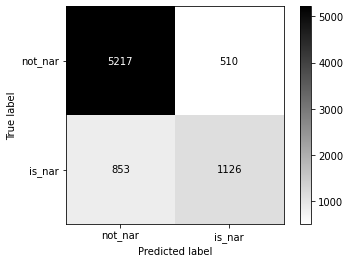

In [148]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))
best_crf = rs.best_estimator_
y_pred  =  best_crf.predict(X_test)
feature_utils.get_prediction_report(flatten(y_test),flatten(y_pred),best_crf.classes_)

### Use custom cv

In [152]:
n_groups=int(test_percent*len(set(groups_train)))
n_groups

12

In [172]:
n_splits=10
my_cv=model_utils.LimitLeavePGroupsOut(n_groups=n_groups,n_splits=n_splits)
for tr,ts in my_cv.split(X_train,y_train,groups_train):
    print (set(itemgetter(*ts)(groups_train)))

{1, 2, 3, 6, 7, 8, 9, 10, 11, 13, 16, 17}
{1, 2, 3, 6, 7, 8, 9, 10, 11, 13, 16, 19}
{1, 2, 3, 6, 7, 8, 9, 10, 11, 13, 16, 20}
{1, 2, 3, 6, 7, 8, 9, 10, 11, 13, 16, 21}
{1, 2, 3, 6, 7, 8, 9, 10, 11, 13, 16, 22}
{1, 2, 3, 6, 7, 8, 9, 10, 11, 13, 16, 23}
{1, 2, 3, 6, 7, 8, 9, 10, 11, 13, 16, 24}
{1, 2, 3, 6, 7, 8, 9, 10, 11, 13, 16, 25}
{1, 2, 3, 6, 7, 8, 9, 10, 11, 13, 16, 26}
{1, 2, 3, 6, 7, 8, 9, 10, 11, 13, 16, 27}


In [181]:
n_splits=10
my_cv=model_utils.ByDocFold(n_groups=n_groups,n_splits=n_splits)
for tr,ts in my_cv.split(X_train,y_train,groups_train):
    tr_gr=set(itemgetter(*ts)(groups_train))
    tr_gr=list(tr_gr)
    tr_gr.sort()
    print ("[{}] {}".format(len(tr_gr),tr_gr))

[12] [1, 6, 16, 20, 23, 35, 37, 42, 69, 73, 76, 78]
[12] [13, 19, 25, 39, 43, 47, 54, 57, 58, 59, 63, 74]
[12] [6, 20, 27, 46, 49, 60, 67, 71, 74, 76, 77, 80]
[12] [6, 7, 8, 16, 17, 44, 45, 68, 74, 76, 77, 78]
[12] [3, 10, 11, 22, 37, 48, 49, 50, 56, 69, 71, 76]
[12] [16, 20, 23, 27, 38, 45, 48, 49, 54, 58, 73, 77]
[12] [1, 7, 11, 23, 26, 27, 37, 41, 42, 53, 54, 61]
[12] [7, 9, 11, 20, 23, 33, 44, 46, 48, 51, 74, 75]
[12] [16, 25, 26, 34, 40, 43, 46, 51, 53, 58, 64, 67]
[12] [2, 9, 10, 11, 23, 26, 47, 54, 66, 71, 73, 78]


In [182]:
n_splits=3
cv_split_ratio=0.1
n_groups=int(cv_split_ratio*len(set(groups_train)))
my_cv=model_utils.ByDocFold(n_groups=n_groups,n_splits=n_splits)
n_groups,n_splits

(6, 3)

In [184]:
%%time

n_splits=3
n_groups=int(cv_split_ratio*len(set(groups_train)))
my_cv=model_utils.ByDocFold(n_groups=n_groups,n_splits=n_splits)

# define fixed parameters and parameters to search
crf = CRF(
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
    'algorithm': ['lbfgs' ,'l2sgd','ap','pa','arow'],
    'min_freq': np.arange(1,11,2) 
}

labels = ['not_nar','is_nar']
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=my_cv,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)


rs.fit(X=X_train, y=y_train,groups=groups_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
126 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimator.py", line 310, in fit
    trainer = self._get_trainer()
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimat

CPU times: user 4min 37s, sys: 49.9 s, total: 5min 26s
Wall time: 5min 50s


RandomizedSearchCV(cv=<model_utils.ByDocFold object at 0x2b8c03780430>,
                   estimator=CRF(all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['lbfgs', 'l2sgd', 'ap',
                                                      'pa', 'arow'],
                                        'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b8c03780e50>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b8c037802e0>,
                                        'min_freq': array([1, 3, 5, 7, 9])},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['not_nar', 'is_nar']),
                   verbose=1)

best params: {'algorithm': 'lbfgs', 'c1': 0.9239591589985864, 'c2': 0.02403435611655303, 'min_freq': 3}
best CV score: 0.7774317775869362
model size: 0.23M

              precision    recall  f1-score   support

     not_nar       0.84      0.93      0.88      5727
      is_nar       0.70      0.48      0.57      1979

    accuracy                           0.81      7706
   macro avg       0.77      0.70      0.73      7706
weighted avg       0.80      0.81      0.80      7706



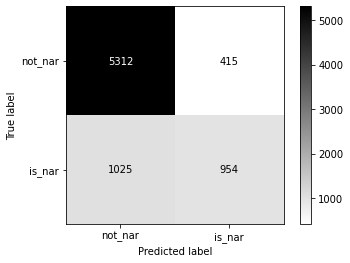

In [185]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))
best_crf = rs.best_estimator_
y_pred  =  best_crf.predict(X_test)
feature_utils.get_prediction_report(flatten(y_test),flatten(y_pred),best_crf.classes_)

### CV on specific indices

In [187]:
dir_name="recalc_tfidf"
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"test_doc_indices.json")
with open(json_path, 'r') as fp:
    test_docs = json.load(fp)

In [188]:
test_docs

[4, 69, 70, 72, 12, 13, 14, 78, 18, 27, 28, 29]

In [189]:
doc_map_path =  os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"docs_map.json")
with open(doc_map_path, 'r') as fp:
    docs_map = json.load(fp)

In [190]:
docs_map = {int(k):v for k,v in docs_map.items()}

In [191]:
imp.reload(model_utils)
seq_len=3
step=3
per_par=True
feature_utils.reshape_docs_map_to_seq(docs_map,per_par,seq_len,step)
X_test,y_test,groups_test = model_utils.get_X_y_by_doc_indices(docs_map,test_docs,seq_len,step)
train_docs = set(docs_map.keys()) - set(test_docs)
X_train,y_train,groups_train = model_utils.get_X_y_by_doc_indices(docs_map,train_docs,seq_len,step)

[68] 439 -> 147 [57] 271 -> 91 [42] 136 -> 46 [63] 338 -> 113 [76] 132 -> 44 [49] 206 -> 69 [21] 108 -> 36 [34] 49 -> 17 [15] 121 -> 41 [39] 111 -> 37 [13] 90 -> 30 [6] 420 -> 140 [27] 67 -> 23 [32] 73 -> 25 [18] 62 -> 21 [65] 335 -> 112 [70] 183 -> 61 [51] 208 -> 70 [44] 199 -> 67 [48] 223 -> 75 [62] 248 -> 83 [77] 176 -> 59 [56] 268 -> 90 [43] 99 -> 33 [69] 517 -> 173 [14] 129 -> 43 [1] 203 -> 68 [20] 90 -> 30 [35] 63 -> 21 [19] 265 -> 89 [26] 114 -> 38 [33] 91 -> 31 [12] 150 -> 50 [7] 248 -> 83 [38] 90 -> 30 [50] 184 -> 62 [45] 204 -> 68 [64] 347 -> 116 [71] 156 -> 52 [2] 156 -> 52 [17] 322 -> 108 [28] 167 -> 56 [80] 223 -> 75 [9] 276 -> 92 [36] 87 -> 29 [23] 74 -> 25 [74] 95 -> 32 [61] 433 -> 145 [40] 148 -> 50 [55] 249 -> 83 [46] 200 -> 67 [53] 149 -> 50 [79] 172 -> 58 [58] 384 -> 128 [72] 420 -> 140 [67] 407 -> 136 [30] 82 -> 28 [25] 122 -> 41 [4] 132 -> 44 [11] 121 -> 41 [37] 99 -> 33 [22] 89 -> 30 [8] 82 -> 28 [29] 105 -> 35 [3] 113 -> 38 [16] 102 -> 34 [41] 137 -> 46 [54] 243 

In [192]:
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"best_params_lemma.word_docFoldCv_2.json")

with open(json_path, 'r') as fp:
    best_params_crf = json.load(fp)
best_params_crf

{'algorithm': 'lbfgs',
 'c1': 0.5052489623208797,
 'c2': 0.03723629092212718,
 'linesearch': 'MoreThuente',
 'min_freq': 9}

In [193]:
crf = CRF(
    **best_params_crf,
    max_iterations=100,
    all_possible_transitions=True,
)
crf.fit(X_train,y_train)
crf

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5052489623208797,
    c2=0.03723629092212718, linesearch='MoreThuente', max_iterations=100,
    min_freq=9)

In [194]:
y_pred=crf.predict(X_test)

CRF alone
              precision    recall  f1-score   support

     not_nar       0.77      0.91      0.84      4029
      is_nar       0.73      0.49      0.58      2074

    accuracy                           0.76      6103
   macro avg       0.75      0.70      0.71      6103
weighted avg       0.76      0.76      0.75      6103



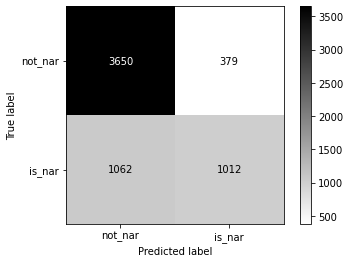

In [196]:
labels = list(crf.classes_)
feature_utils.get_prediction_report(flatten(y_test),flatten(y_pred),labels,"CRF alone")